In [1]:
'''
Reading basic data from iphone inputs
'''

'\nReading basic data from iphone inputs\n'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import os
import sys
from operator import itemgetter
import random
from optparse import OptionParser
from copy import copy
import numpy as np
from scipy.stats import kstest, mstats
import string
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import defaultdict
# import pymc as pm

src_dir = os.path.abspath(os.path.join(os.pardir, os.pardir, 'src'))
sys.path[0] = src_dir
import parsers.checklistevaluator as checkeval

In [4]:
patient_file = '../../data/iphone_responses/backend_patient.csv'
dtypes = [string]

In [5]:
df_patient = pd.read_csv(patient_file)
patient_list = df_patient.hash_fin.tolist()

In [6]:
user_file = '../../data/iphone_responses/auth_user.csv'
dtypes = [int, string, datetime, int, string, string, string, string, int, int, datetime]

In [7]:
df_user = pd.read_csv(user_file, parse_dates=['last_login', 'date_joined'])
admin_list = ['anna', 'john', 'mbechel1', 'memorial', 'admin', 'nm175316']
df_user[df_user.username.isin(admin_list)].id

0    2
1    3
2    4
3    5
4    7
5    8
Name: id, dtype: int64

In [8]:
df_user = df_user[~df_user['username'].isin(admin_list)]

In [9]:
user_list = df_user.username.unique().tolist()

In [10]:
user_id_list = df_user[df_user.username.isin(user_list)]['id'].unique().tolist()

In [11]:
response_file = '../../data/iphone_responses/backend_patientresponse.csv'
dtypes = {'id': int, 'question_id': str, 'workday': str, 
          'response': str, 'date': str, 'patient_id': str, 'checklist_id': int, 'user_id': int}
df_response = pd.read_csv(response_file, parse_dates=['date'],dtype=dtypes)
df_response = df_response[466:]
df_response = df_response[df_response['user_id'].isin(user_id_list)]

In [12]:
df_response.question_id.iloc[0]

'0701'

### Doctor-Patient
which doctors were in charge of which patient?
were there ever an overlapping?

In [13]:
question_list = df_response.question_id.unique().tolist()

In [14]:
doctor_patient_dict = {doc: [] for doc in user_id_list}
patient_doctor_dict = {pat: [] for pat in patient_list}

In [15]:
for index, row in df_response.iterrows():
    doc = row.user_id
    pat = row.patient_id
    #gettign the list of patient that the doctor had
    if pat not in doctor_patient_dict[doc]:
        doctor_patient_dict[doc].append(pat)
    #getting the list of doctors the patient had
    if doc not in patient_doctor_dict[pat]:
        patient_doctor_dict[pat].append(doc)

In [16]:
date_list = df_response.workday.astype(datetime.datetime).unique().tolist()
print(type(date_list[0]))

<class 'str'>


In [17]:
doc_pat_answer_dict = {doc: {p: [] for p in pats}
                            for doc, pats in doctor_patient_dict.items()} 

In [18]:
bool(doc_pat_answer_dict[10])

False

In [19]:
df_response.tail(10)

,id,question_id,workday,response,date,patient_id,checklist_id,user_id
3752,3765,$0101,2016-11-18,Y,2016-11-18 15:50:15,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3753,3766,$0201,2016-11-18,Y,2016-11-18 15:50:20,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3754,3767,$0203,2016-11-18,N,2016-11-18 15:50:18,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3755,3768,$0202,2016-11-18,N,2016-11-18 15:50:21,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3756,3769,$0801,2016-11-18,Y,2016-11-18 15:50:24,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3757,3770,$0601,2016-11-18,N,2016-11-18 15:50:32,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3758,3771,$0301,2016-11-18,N,2016-11-18 15:50:37,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3759,3772,$0401,2016-11-18,N,2016-11-18 15:50:39,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3760,3773,$0501,2016-11-18,N,2016-11-18 15:50:41,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58
3761,3774,$0702,2016-11-18,Y,2016-11-18 15:52:27,fa4c24ee999d3cae5074d01de8c01256527143f2,3,58


In [21]:
#Looking at what kind of questions has been answered for each patient
for index, row in df_response.iterrows():
    doc = row.user_id
    pat = row.patient_id
    question = row.question_id
    if '$' in question:
        question = question[1:]
    response = row.response
    workday = row.workday
#     print(workday, type(workday))
    doc_pat_answer_dict[doc][pat].append({'Q': question, 'R': response, 'T': workday})


## Helio's code 

In [22]:
class PatientEntry:
    def __init__(self):
        self.apache_is_completed = True
        self.has_antibiotics = True
        self.has_lines = True
        self.has_medication = True
        self.has_ventilation = True

In [23]:
checklist = {"order": "(01,{03|06|07|08},10)", "description": "No ARDS", "id": "1", "groups": [{"title": "Ventilator & Sedation Weaning", "sections": [{"title": "Sedation:", "dependence": "hasMedication", "questions": [{"indentation": 0, "dependence": "true", "text": "Has a sedation awakening trial (SAT) been performed today?", "questionType": "Q", "id": "0101"}, {"indentation": 0, "dependence": "!0101", "text": "Is it appropriate to perform an SAT today?", "questionType": "Q", "id": "0102"}], "id": "0100"}, {"title": "Ventilator weaning:", "dependence": "(0101|0102)&hasVentilation", "questions": [{"indentation": 0, "dependence": "true", "text": "Has a spontaneous breathing trial (SBT) been performed today?", "questionType": "Q", "id": "0201"}, {"indentation": 0, "dependence": "0201", "text": "Can the patient be extubated today?", "questionType": "Q", "id": "0202"}, {"indentation": 0, "dependence": "!0201", "text": "Is it appropriate to perform an SBT today?", "questionType": "Q", "id": "0203"}], "id": "0200"}], "dependence": "hasVentilation", "id": "01", "emrInfoId": "VENTILATOR_WEANING"}, {"title": "Vascular Access, Urinary Catheter & Nutrition", "sections": [{"title": "Vascular access:", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Can any central venous or arterial lines be removed?", "questionType": "Q", "id": "0301"}], "id": "0300"}, {"title": "Urinary catheters:", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Can the urinary catheter be removed today?", "questionType": "Q", "id": "0401"}], "id": "0400"}, {"title": "Nutrition:", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Is it appropriate to increase nutrition today?", "questionType": "Q", "id": "0501"}], "id": "0500"}], "dependence": "true", "id": "03", "emrInfoId": "LINES_FOOD"}, {"title": "Antibiotics", "sections": [{"title": "", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Can antibiotic coverage be stopped or narrowed today?", "questionType": "Q", "id": "0601"}], "id": "0600"}], "dependence": "hasAntibiotics", "id": "06", "emrInfoId": "ANTIBIOTICS"}, {"title": "DVT", "sections": [{"title": "", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Is the patient on appropriate DVT chemoprophylaxis?", "questionType": "Q", "id": "0701"}, {"indentation": 0, "dependence": "true", "text": "Can the patient's mobility be increased today?", "questionType": "Q", "id": "0702"}], "id": "0700"}], "dependence": "true", "id": "07", "emrInfoId": "DVT"}, {"title": "Pressure Ulcers", "sections": [{"title": "", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "Has the patient been reviewed for pressure ulcers today?", "questionType": "Q", "id": "0801"}], "id": "0800"}], "dependence": "true", "id": "08", "emrInfoId": "PRESSURE_ULCERS"}, {"title": "Apache", "sections": [{"title": "", "dependence": "true", "questions": [{"indentation": 0, "dependence": "true", "text": "APACHE form is not complete. Please fill out the APACHE form.", "questionType": "T", "id": "1001"}], "id": "1000"}], "dependence": "!apacheIsCompleted", "id": "10", "emrInfoId": "NO"}]}

In [24]:
workday_list = df_response.workday.unique().tolist()

In [25]:
daily_response_dict = {}
# patient_user = defaultdict(lambda: set())

for workday in workday_list:
    all_responses = defaultdict(lambda: {})
    for index, row in df_response[df_response['workday']==workday].iterrows():
        patient_id = row['patient_id']
        question_id = row['question_id']
        response = row['response']
        try:
            if len(response.strip()) > 0:
                all_responses[patient_id][question_id] = response
                user_id = row['user_id']
#                 patient_user[patient_id].add(user_id)
        except AttributeError:
            pass
    daily_response_dict[workday] = all_responses

In [28]:
result  = {}
for day, all_responses in daily_response_dict.items():
    status = {}
    for hash_fin, responses in all_responses.items():
#         print("Patient : {}".format(hash_fin))
#         print("Patient: {}, \n\t responses: {}".format(hash_fin, responses))
        entry = PatientEntry()
        evaluator = checkeval.MathExpressionEvaluator(entry, responses)
        questions = 0
        answered = 0
        for group in checklist["groups"]:
            group_visible = evaluator.convert_expression_and_evalute(group['dependence'])
            #print("group_visible: {}, {}".format(group['dependence'], group_visible))
            for section in group["sections"]:
                section_visible = group_visible and evaluator.convert_expression_and_evalute(section['dependence'])
                for question in section["questions"]:
                    question_visible = section_visible and evaluator.convert_expression_and_evalute(question['dependence'])
                    if question_visible:
                        questions += 1
                        if question['id'] in responses:
                            #print("{} - Y".format(question['id']))
                            answered += 1
                        else:
                            #print("{} - N".format(question['id']))
                            pass
        doc = df_response.user_id[(df_response['workday'] == day) & (df_response['patient_id'] == hash_fin)].unique().tolist()
        if len(doc) == 1:
            status[hash_fin] = (float(answered) / float(questions) if questions > 0 else 0, doc[0])
        else:
            status[hash_fin] = (float(answered) / float(questions) if questions > 0 else 0, doc)
    result[day] =  status


In [30]:
checklist_completion_dict = {d: [] for d in user_id_list if bool(doc_pat_answer_dict[d]) == True}
for day, response in result.items():
    for pat, val in response.items():
        doc = val[1]
        completion = val[0]
        checklist_completion_dict[doc].append(completion)



In [31]:
complete_to_incomplete = {d: [] for d in checklist_completion_dict.keys()}
incomplete = {d: [] for d in checklist_completion_dict.keys()}

In [32]:
for key, val in checklist_completion_dict.items():
    complete_count = val.count(1.0)
    complete_to_incomplete[key] = [complete_count/len(val), 1 - complete_count/len(val)]

In [33]:
complete_to_incomplete

{18: [0.0, 1.0],
 20: [0.043478260869565216, 0.9565217391304348],
 54: [0.06451612903225806, 0.935483870967742],
 55: [0.038461538461538464, 0.9615384615384616],
 56: [0.06521739130434782, 0.9347826086956522],
 57: [0.16666666666666666, 0.8333333333333334],
 58: [0.17829457364341086, 0.8217054263565892]}

In [34]:
doctor_names = list(complete_to_incomplete.keys())
complete_ratios = list(complete_to_incomplete[d][0] for d in doctor_names)
doctor_names = [str(doc) for doc in doctor_names]

In [35]:
#Add text with mean and standard deviation!!!

In [36]:
import matplotlib.ticker as ticker

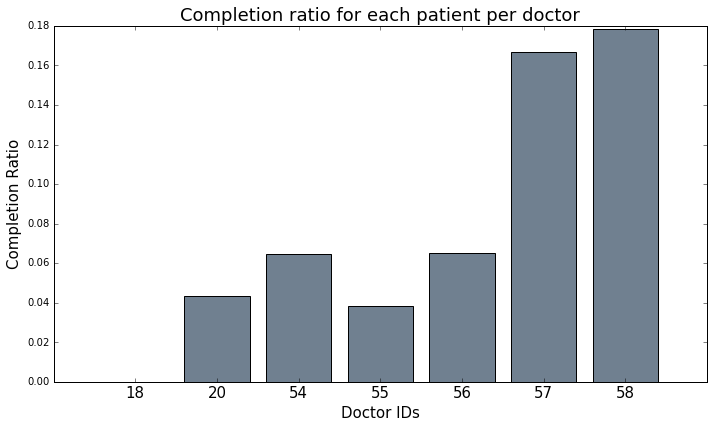

In [37]:
font_size = 15

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(range(len(doctor_names)), complete_ratios, align='center', color='slategray')

ax.set_xticks(range(len(doctor_names)))
ax.set_xticklabels(doctor_names, fontsize=font_size)

ax.set_xlabel('Doctor IDs', fontsize=font_size)
ax.set_ylabel('Completion Ratio', fontsize=font_size)
plt.title('Completion ratio for each patient per doctor', fontsize=1.2*font_size)
plt.tight_layout()
plt.savefig('../../result/iphoneapp/checklist_completion_ratio_111816.png', transparent=True)

In [39]:
doctors = []
complete = []
not_complete = []
for key, val in checklist_completion_dict.items():
    doctors.append(key)
    complete.append(val.count(1.0))
    not_complete.append(len(val))


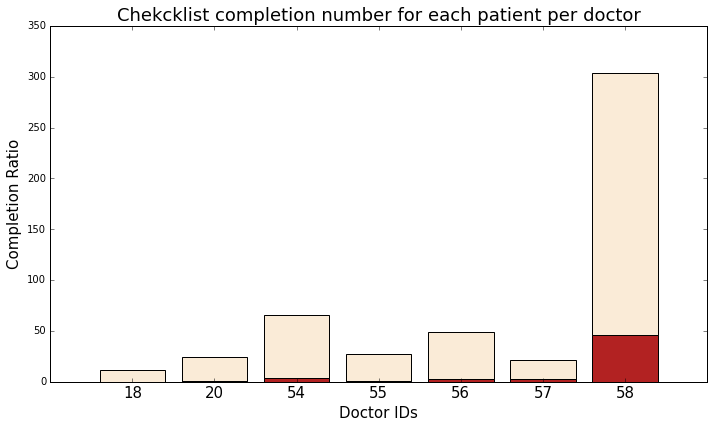

In [40]:
font_size = 15

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(range(len(doctors)), complete, align='center', color='firebrick')
ax.bar(range(len(doctors)), not_complete, align='center', color='antiquewhite', bottom=complete)
ax.set_xticks(range(len(doctor_names)))
ax.set_xticklabels(doctor_names, fontsize=font_size)

ax.set_xlabel('Doctor IDs', fontsize=font_size)
ax.set_ylabel('Completion Ratio', fontsize=font_size)
plt.title('Chekcklist completion number for each patient per doctor', fontsize=1.2*font_size)
plt.tight_layout()
plt.savefig('../../result/iphoneapp/checklist_completion_raw_num_111718.png', transparent=True)

In [41]:
doctors[:-1]

[18, 20, 54, 55, 56, 57]

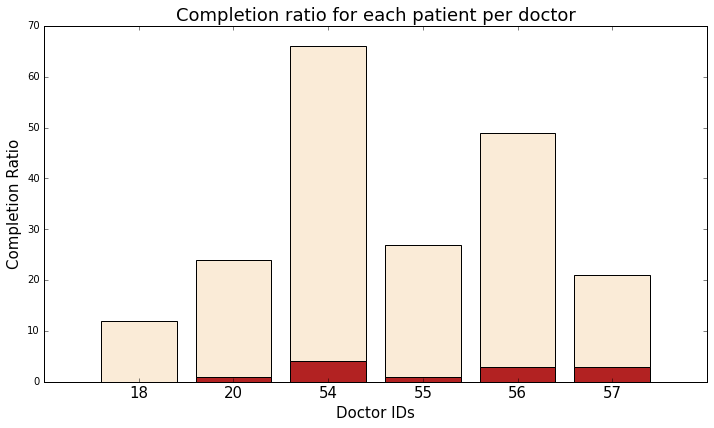

In [42]:
font_size = 15

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(range(len(doctors[:-1])), complete[:-1], align='center', color='firebrick')
ax.bar(range(len(doctors[:-1])), not_complete[:-1], align='center', color='antiquewhite', bottom=complete[:-1])
ax.set_xticks(range(len(doctor_names[:-1])))
ax.set_xticklabels(doctor_names[:-1], fontsize=font_size)

ax.set_xlabel('Doctor IDs', fontsize=font_size)
ax.set_ylabel('Completion Ratio', fontsize=font_size)
plt.title('Completion ratio for each patient per doctor', fontsize=1.2*font_size)
plt.tight_layout()
plt.savefig('../../result/iphoneapp/checklist_completion_raw_num_wo_58_111816.png', transparent=True)

## Ratio of completion for cases doctors have not  completed the checklist

In [43]:
incomplete_dist = {}
for key, val in checklist_completion_dict.items():
    incomplete_list = [v for v in val if v < 1.0]
    incomplete_dist[key] = [np.mean(incomplete_list), np.std(incomplete_list)] 
    

In [44]:
means = []
stds = []
names = []
for key, val in incomplete_dist.items():
    names.append(key)
    stds.append(val[1])
    means.append(val[0])

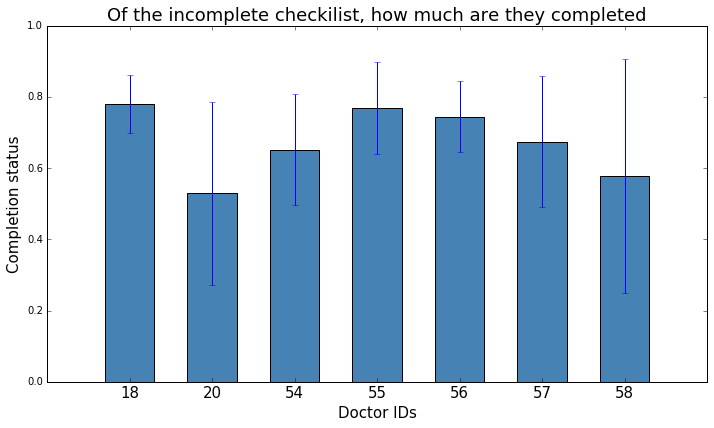

In [45]:
width = 0.6

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(len(names)), means, width, color='steelblue', yerr=stds, align='center')

ax.set_xticks(range(len(doctor_names)))
ax.set_xticklabels(names, fontsize=font_size)
ax.set_ylim([0., 1.])

ax.set_xlabel('Doctor IDs', fontsize=font_size)
ax.set_ylabel('Completion status', fontsize=font_size)
plt.title('Of the incomplete checkilist, how much are they completed', fontsize=1.2*font_size)

plt.tight_layout()
plt.savefig('../../result/iphoneapp/completion_ratio_111816.png', transparent=True)